In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from surprise import KNNWithMeans,accuracy,Dataset, Reader
from surprise.model_selection import train_test_split

In [2]:
ratings_data = pd.read_csv('Electronic_dataset.csv')

In [3]:
ratings_data.head()

,user_id,prod_id,ratings,timestamp
0,A3L1GVWVJKWZZS,B0058UUR6E,5.0,1364774400
1,A08831071BVKZMKNCPI5S,B009ID0VVS,5.0,1357257600
2,A1SINU2I4IOPNU,B000GBO9IM,4.0,1358121600
3,A3P3P31EEOX2BD,B00CDCIOHO,3.0,1404950400
4,A3DBLJ3MPBJQMN,B000MS3VGA,5.0,1294444800


In [4]:
# Dropping the timestamp column as it is not required for our analysis
ratings_data.drop('timestamp', axis=1, inplace=True)

# EDA

In [5]:
ratings_data.describe().T

,count,mean,std,min,25%,50%,75%,max
ratings,500000.0,4.013172,1.379996,1.0,3.0,5.0,5.0,5.0


In [6]:
ratings_data.shape

(500000, 3)

In [7]:
# Checking for null values and data types
ratings_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 3 columns):
user_id    500000 non-null object
prod_id    500000 non-null object
ratings    500000 non-null float64
dtypes: float64(1), object(2)
memory usage: 11.4+ MB


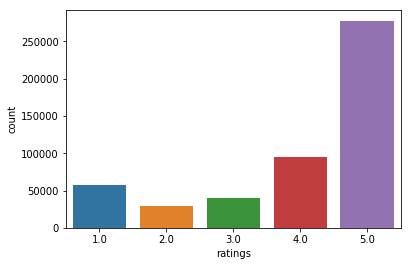

In [56]:
# Checking the count for each rating
sns.countplot(x=ratings_data['ratings'])

In [48]:
# Checking the number of users who have rated each rating
ratings_data['ratings'].value_counts()

5.0    277826
4.0     95089
1.0     57452
3.0     40382
2.0     29251
Name: ratings, dtype: int64

In [49]:
# Finding out the avg rating for each product
ratings_data.groupby('prod_id')['ratings'].mean().head()

prod_id
0439886341    1.0
0528881469    5.0
0594012015    5.0
0594033926    5.0
0594451647    5.0
Name: ratings, dtype: float64

In [50]:
# Finding out the avg rating for each product in a descending order
ratings_data.groupby('prod_id')['ratings'].mean().sort_values(ascending=False).head()

prod_id
BT008G3W52    5.0
B004AC52UC    5.0
B004AGJRMC    5.0
B004AGED3A    5.0
B004AFOK2U    5.0
Name: ratings, dtype: float64

In [51]:
# Finding the total number of ratings each product has got in a descending order
ratings_data.groupby('prod_id')['ratings'].count().sort_values(ascending=False).head()

prod_id
B0074BW614    1138
B00DR0PDNE    1094
B007WTAJTO     883
B0019EHU8G     774
B006GWO5WK     770
Name: ratings, dtype: int64

In [52]:
ratings_mean_count = pd.DataFrame(ratings_data.groupby('prod_id')['ratings'].mean())

In [53]:
ratings_mean_count['rating_counts']=pd.DataFrame(ratings_data.groupby('prod_id')['ratings'].count())

#### We are assuming a product with high ratings will have high number of rating counts as well as a good product will be rated by many. Let's check if that is true.

<Figure size 576x432 with 0 Axes>

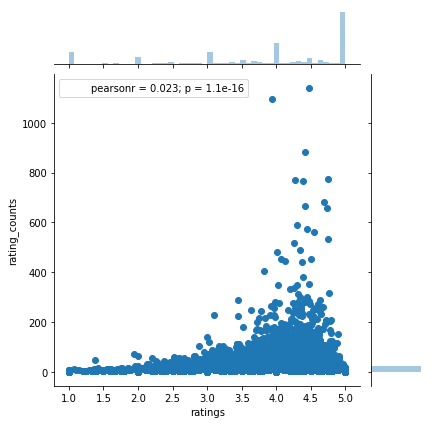

In [54]:
plt.figure(figsize=(8,6))
sns.jointplot(x='ratings', y='rating_counts', data=ratings_mean_count)

#### The above graph shows that, in general, products with higher average ratings actually have more number of ratings, compared with products that have lower average ratings.

#### Let's create a popularity based recommendation model for products having a user rating of 4.5 or above with a good number of rating counts

In [55]:
ratings_mean_count[ratings_mean_count['ratings'] >= 4.5].sort_values(by=['rating_counts','ratings'],ascending=False).head()

,ratings,rating_counts
prod_id,,
B0019EHU8G,4.740310,774
B003ES5ZUU,4.684288,681
B007R5YDYA,4.738998,659
B003LR7ME6,4.546263,562
B000LRMS66,4.745318,534


# Collaborative Filtering model

In [20]:
ratings_data_final.head()

,user_id,prod_id,ratings
296595,A173814OIKA2OY,B00BCGRYY6,4.0
17749,A1KP9ODT16D07B,B0079LGKBQ,5.0
3166,A8775XY1XXKDL,B001HTE414,5.0
381803,ABV3HS228V0HN,B000234U3I,5.0
427029,A3Q3USPMHAR6C2,B00B7N997O,4.0


In [35]:
# Creating a copy of the ratings_data_final dataframe

ratings_data_final_bkup = ratings_data.copy()

#### Subsetting the dataframe based on rating_counts greater than 5 to avoid memory issues

In [118]:
user_counts = pd.DataFrame(ratings_data.groupby('user_id')['ratings'].count())
final_users = user_counts[user_counts['ratings']>=5]
final_users.reset_index(inplace=True)
ratings_final = ratings_data[ratings_data['user_id'].isin(final_users['user_id'])]

In [119]:
print(ratings_final.shape)
ratings_final.head()

(8447, 3)


,user_id,prod_id,ratings
26,A2HX3D3MPPASNS,B004I3VZM2,4.0
214,AZNUHQSHZHSUE,B000FJEYZI,1.0
264,A1YEPFLLH42OU1,B00E3W15P0,5.0
286,A2GYV87WW0DMSN,B0009Y7APU,5.0
326,A2IXMLO29Z5G8S,B002K46DDC,5.0


#### The above subset dataset comprises of those users only who have rated 5 or more times at least. We have eliminated all those datapoint for which users have rated less than 10 products. This will allow us to have a better user user Collaborative filtering.

5.0    4818
4.0    2090
3.0     786
2.0     384
1.0     369
Name: ratings, dtype: int64


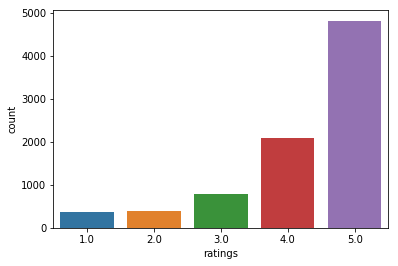

In [95]:
sns.countplot(x=ratings_final['ratings'])
print(ratings_final['ratings'].value_counts())

    o The above plot shows that products with better ratings (4 or 5) is more likely to be rated by more number of users

#### Spliting the data randomly into a train and test dataset(70:30)

In [96]:
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(ratings_final,reader)
trainset,testset = train_test_split(data, test_size=0.3, random_state=100)

In [112]:
model = KNNWithMeans(k=50, sim_options={'name': 'cosine', 'user_based': True},random_state=100)

In [113]:
model.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [114]:
knn_pred = model.test(testset)

In [115]:
print("RMSE score for cosine KNN Model for User-based Collaborative Filtering, using 50 neighbors gives")
accuracy.rmse(knn_pred, verbose=True)

RMSE score for cosine KNN Model for User-based Collaborative Filtering, using 50 neighbors gives
RMSE: 1.0897


1.089688603934386

#### The objective is to reccommend top K (K=5) recommendations of new products to each user based on his/her habits

In [101]:
new_test_df = trainset.build_anti_testset()

In [102]:
pred = model.test(new_test_df)

In [103]:
pred_df = pd.DataFrame([[x.uid,x.iid,x.est] for x in pred])

In [104]:
# Renaming columns
pred_df.columns = ["user_id","prod_id","est_rating"]

In [105]:
pred_df.sort_values(by = ["user_id","prod_id","est_rating"],ascending=False,inplace=True)

In [106]:
#showing the top-5 recommendations in general
pred_df.head()

,user_id,prod_id,est_rating
2000110,AZNUHQSHZHSUE,B00L26YDA4,4.0
1996837,AZNUHQSHZHSUE,B00L2442H0,4.0
1998675,AZNUHQSHZHSUE,B00KYMCJF8,4.0
1998338,AZNUHQSHZHSUE,B00KWMNDDM,4.0
2000270,AZNUHQSHZHSUE,B00KMRGB7C,4.0


In [111]:
#Predicting top-5 products for 1 particular user
pred_df[pred_df['user_id']=='A2HX3D3MPPASNS'].head()

,user_id,prod_id,est_rating
2205296,A2HX3D3MPPASNS,B00L26YDA4,4.75
2202023,A2HX3D3MPPASNS,B00L2442H0,4.75
2203862,A2HX3D3MPPASNS,B00KYMCJF8,4.75
2203526,A2HX3D3MPPASNS,B00KWMNDDM,4.75
2205456,A2HX3D3MPPASNS,B00KMRGB7C,4.75


# Summary

### Popularity recommendations system   
    
    o A Popularity based recommendations system has been designed in order to predict the top 5 most popular products based on User ratings and the number of users who have rated the product.
   
    o This Popularity based recommendation system doesn't need to have historical knowledge of the user and anybody who buys products from the ecommerce site will be catered with this recommendation system
    
    o However there is a downside to this type of Recommendation engine. It is not customizable. So any user who logs in to the ecommerce site will get the same top5 product recommendation as it simply prioritizes the products which have been rated the most and the highest.
    
    
### Collaborative filtering recommendation system

    o The initial dataset has 500000 data points and if we had built a collaborative recommendation based on the initial dataset, we could've faced memory issues.
    o To avoid memory issues, we first created a subset of the initial dataset by looking at those users only who have rated products atleast more than 5 times. There are 8447 data points for such users
    o The RMSE that we have achieved using this technique from a collaborative filtering recommendation model based on cosine similarity is 1.09.
    o If we had considered users who have atleast rated 10 or 15 products, the RMSE could come down making it a more effective recommender engine but then the user base for whom we would be creating this recommender engine will be less.
    
    o If we had selected only those users who have rated 10 or more products then we would have a mere 1875 data points.  So, I've taken a subjective call to choose users who have atleast rated 5 products.